In [1]:
%%capture
%pip install neattext
%pip install torchtext
%python -m spacy download en
%pip install -q -U "tensorflow-text==2.8.*"
%pip install numpy==1.23.0
%pip install tensorflow-text
%pip install convokit
%pip install keras_tuner

In [1]:
%%capture
import pandas as pd
import os
import re
import neattext as nt
from neattext.explainer import emoji_explainer
from neattext import TextExtractor
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Bidirectional, LSTM, Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

import shutil
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
from utils import load_emodec_tweets, load_wassa, normalize_text, create_tf_datasets, create_tf_dataset, classification_report
import keras_tuner as kt
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
from tuning import MetaRNN, tune_model
import pickle as pkl
from joblib import dump, load
import seaborn as sns
import copy

In [2]:
emodec = load_emodec_tweets()
emodec = emodec.applymap(func=normalize_text)
emodec = emodec.loc[ (emodec['content'] !='') & (emodec['content'] != ' ')] 
emodec = emodec.loc[ (emodec['sentiment'] == 'surprise') | (emodec['sentiment']=='anger')] 

In [3]:
wassa = load_wassa()
wassa = wassa.applymap(func=normalize_text)
wassa = wassa.loc[ (wassa['content'] !='') & (wassa['content'] != ' ')]

In [4]:
data = pd.concat([emodec, wassa])
data = data.sample(frac = 1)

In [5]:
data.groupby('sentiment').count()

,content
sentiment,
anger,1051
fear,2251
joy,1615
sadness,1533
surprise,2185


## RNN based on static TextVectorizer

In [40]:
def build_rnn(train_dataset):
    encoder = TextVectorization()
    encoder.adapt(train_dataset.map(lambda text, label: text))
    model = Sequential()
    model.add(encoder)
    model.add(Embedding(len(encoder.get_vocabulary()), 200, mask_zero=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dense(5, activation = 'softmax'))
    model.compile(loss = CategoricalCrossentropy(),
                  optimizer=Adam(1e-4),
                  metrics=['accuracy'])
    return model

### Fixed Model CV

In [41]:
BATCH_SIZE = 64
confusion_matrices = []
metrics_rnn = {'accuracy': [], 'f1_score_weighted': [], 'f1_score_micro': [], 'f1_score_macro': []}
trained_models = []

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in skf.split(data['content'], data['sentiment']):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    train_dataset = create_tf_dataset(train, BATCH_SIZE) #Make datasets compatible with tensorflow
    test_dataset = create_tf_dataset(test, BATCH_SIZE)
    
    rnn_model = build_rnn(train_dataset)
    history = rnn_model.fit(train_dataset,
                            epochs=10,
                            validation_data=test_dataset)
    trained_models.append(rnn_model)
    
    y_pred = rnn_model.predict(test_dataset)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in test_dataset], axis=0)
    true_categories = tf.argmax(true_categories, axis=1)
    cm = confusion_matrix(predicted_categories, true_categories)
    
    confusion_matrices.append(cm)
    metrics_rnn['accuracy'].append(accuracy_score(true_categories, predicted_categories))
    metrics_rnn['f1_score_macro'].append(f1_score(true_categories, predicted_categories, average='macro'))
    metrics_rnn['f1_score_micro'].append(f1_score(true_categories, predicted_categories, average='micro'))
    metrics_rnn['f1_score_weighted'].append(f1_score(true_categories, predicted_categories, average='weighted'))

Epoch 1/10
122/122 [==============================] - 241s 2s/step - loss: 1.5989 - accuracy: 0.2890 - val_loss: 1.5874 - val_accuracy: 0.3218
Epoch 2/10
122/122 [==============================] - 212s 2s/step - loss: 1.5617 - accuracy: 0.3310 - val_loss: 1.5463 - val_accuracy: 0.3009
Epoch 3/10
122/122 [==============================] - 195s 2s/step - loss: 1.4683 - accuracy: 0.3736 - val_loss: 1.4245 - val_accuracy: 0.4549
Epoch 4/10
122/122 [==============================] - 209s 2s/step - loss: 1.1796 - accuracy: 0.7047 - val_loss: 1.1655 - val_accuracy: 0.7049
Epoch 5/10
122/122 [==============================] - 215s 2s/step - loss: 0.8393 - accuracy: 0.8245 - val_loss: 1.0106 - val_accuracy: 0.7373
Epoch 6/10
122/122 [==============================] - 220s 2s/step - loss: 0.6034 - accuracy: 0.8846 - val_loss: 0.9230 - val_accuracy: 0.7616
Epoch 7/10
122/122 [==============================] - 209s 2s/step - loss: 0.4519 - accuracy: 0.9241 - val_loss: 0.8818 - val_accuracy: 0.7778

14/14 [==============================] - 33s 347ms/step
Epoch 1/10
122/122 [==============================] - 217s 2s/step - loss: 1.5979 - accuracy: 0.2782 - val_loss: 1.5841 - val_accuracy: 0.3148
Epoch 2/10
122/122 [==============================] - 188s 2s/step - loss: 1.5564 - accuracy: 0.2872 - val_loss: 1.5419 - val_accuracy: 0.3113
Epoch 3/10
122/122 [==============================] - 167s 1s/step - loss: 1.4511 - accuracy: 0.3853 - val_loss: 1.4224 - val_accuracy: 0.5220
Epoch 4/10
122/122 [==============================] - 161s 1s/step - loss: 1.1884 - accuracy: 0.6443 - val_loss: 1.1959 - val_accuracy: 0.6042
Epoch 5/10
122/122 [==============================] - 201s 2s/step - loss: 0.8636 - accuracy: 0.8104 - val_loss: 1.0001 - val_accuracy: 0.7188
Epoch 6/10
122/122 [==============================] - 198s 2s/step - loss: 0.6020 - accuracy: 0.8897 - val_loss: 0.9241 - val_accuracy: 0.7477
Epoch 7/10
122/122 [==============================] - 194s 2s/step - loss: 0.4406 - ac

Epoch 6/10
122/122 [==============================] - 162s 1s/step - loss: 0.5872 - accuracy: 0.8766 - val_loss: 0.9499 - val_accuracy: 0.7346
Epoch 7/10
122/122 [==============================] - 166s 1s/step - loss: 0.4423 - accuracy: 0.9179 - val_loss: 0.9275 - val_accuracy: 0.7543
Epoch 8/10
122/122 [==============================] - 177s 1s/step - loss: 0.3517 - accuracy: 0.9372 - val_loss: 0.9309 - val_accuracy: 0.7578
Epoch 9/10
122/122 [==============================] - 158s 1s/step - loss: 0.2859 - accuracy: 0.9471 - val_loss: 0.9498 - val_accuracy: 0.7636
Epoch 10/10
14/14 [==============================] - 10s 314ms/step
Epoch 1/10
122/122 [==============================] - 147s 1s/step - loss: 1.6001 - accuracy: 0.3035 - val_loss: 1.5895 - val_accuracy: 0.3662
Epoch 2/10
122/122 [==============================] - 129s 1s/step - loss: 1.5640 - accuracy: 0.3773 - val_loss: 1.5463 - val_accuracy: 0.3592
Epoch 3/10
122/122 [==============================] - 128s 1s/step - loss:

In [59]:
classification_report(metrics_rnn)

accuracy mean 0.766651377623278
accuracy std 0.01782748387198685
f1_score_weighted mean 0.7670225486438981
f1_score_weighted std 0.017369684375409946
f1_score_micro mean 0.766651377623278
f1_score_micro std 0.01782748387198683
f1_score_macro mean 0.7567368423412212
f1_score_macro std 0.017310085785976394


Text(33.0, 0.5, 'Actual')

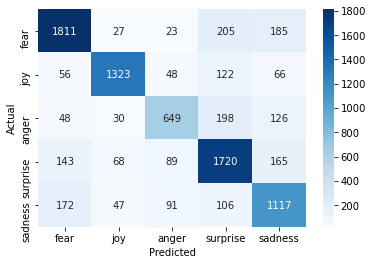

In [88]:
final_cm = copy.copy(confusion_matrices[0])
for cm in confusion_matrices[1:]:
    final_cm += cm
    
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'], 
            yticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [60]:
%%capture
with open('dumped_files/metrics_rnn_fixed.pickle', 'wb') as f:
    pkl.dump(metrics_rnn_tuning, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('dumped_files/cm_rnn_fixed.pickle', 'wb') as f:
    pkl.dump(confusion_matrices, f, protocol=pkl.HIGHEST_PROTOCOL)
    
for index, model in enumerate(trained_models):
    model.save('dumped_files/rnn_fixed_'+str(index))

### Tuning hyper-parameters

In [6]:
BATCH_SIZE = 64
confusion_matrices = []
metrics_rnn_tuning = {'accuracy': [], 'f1_score_weighted': [], 'f1_score_micro': [], 'f1_score_macro': []}
results_summary_list = []
trained_models = []

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(skf.split(data['content'], data['sentiment'])):
    train_val = data.iloc[train_index]
    test = data.iloc[test_index]
    
    train, val = train_test_split(train_val, test_size=0.2, stratify = train_val['sentiment'])
    train_dataset = create_tf_dataset(train, BATCH_SIZE) #Make datasets compatible with tensorflow
    val_dataset = create_tf_dataset(val, BATCH_SIZE)
    test_dataset = create_tf_dataset(test, BATCH_SIZE)
    
    meta_rnn_model = MetaRNN(train_dataset)
    best_model, results_summary = tune_model(meta_rnn_model, 'MetaRNN',train_dataset, val_dataset, test_dataset, i)

    trained_models.append(best_model)
    results_summary_list.append(results_summary)
    
    y_pred = best_model.predict(test_dataset)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in test_dataset], axis=0)
    true_categories = tf.argmax(true_categories, axis=1)
    cm = confusion_matrix(predicted_categories, true_categories)
    
    confusion_matrices.append(cm)
    metrics_rnn_tuning['accuracy'].append(accuracy_score(true_categories, predicted_categories))
    metrics_rnn_tuning['f1_score_macro'].append(f1_score(true_categories, predicted_categories, average='macro'))
    metrics_rnn_tuning['f1_score_micro'].append(f1_score(true_categories, predicted_categories, average='micro'))
    metrics_rnn_tuning['f1_score_weighted'].append(f1_score(true_categories, predicted_categories, average='weighted'))

Trial 20 Complete [00h 38m 18s]
val_accuracy: 0.828938901424408

Best val_accuracy So Far: 0.8463022708892822
Total elapsed time: 18h 11m 21s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in tuning/MetaRNNholdout9
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
embedding_dim: 200
drop_rate: 0.9
lr: 0.006175243351932823
Score: 0.8463022708892822
Trial summary
Hyperparameters:
embedding_dim: 300
drop_rate: 0.1
lr: 0.0049666001363061225
Score: 0.8392282724380493
Trial summary
Hyperparameters:
embedding_dim: 100
drop_rate: 0.30000000000000004
lr: 0.008598687167466736
Score: 0.8379421234130859
Trial summary
Hyperparameters:
embedding_dim: 200
drop_rate: 0.8
lr: 0.0035249440957205477
Score: 0.8321543335914612
Trial summary
Hyperparameters:
embedding_dim: 200
drop_rate: 0.30000000000000004
lr: 0.007993162537476103
Score: 0.8321543335914612
Trial summary
Hyperparameters:
embedding_dim: 300
drop_rate: 0.8
lr: 0.00324429592474

In [9]:
classification_report(metrics_rnn_tuning)

accuracy mean 0.8340469561392215
accuracy std 0.013882713000632096
f1_score_weighted mean 0.8339231386605854
f1_score_weighted std 0.014067973253402496
f1_score_micro mean 0.8340469561392215
f1_score_micro std 0.013882713000632096
f1_score_macro mean 0.8304362738107267
f1_score_macro std 0.014327141997793275


Text(33.0, 0.5, 'Actual')

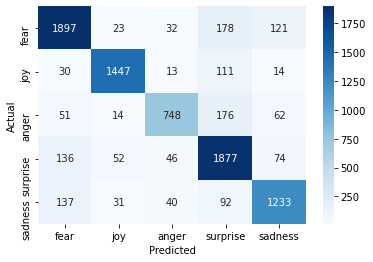

In [76]:
final_cm = copy.copy(confusion_matrices[0])
for cm in confusion_matrices[1:]:
    final_cm += cm
    
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'], 
            yticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [26]:
%%capture
with open('dumped_files/metrics_rnn_tuning.pickle', 'wb') as f:
    pkl.dump(metrics_rnn_tuning, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('dumped_files/cm_rnn_tuning.pickle', 'wb') as f:
    pkl.dump(confusion_matrices, f, protocol=pkl.HIGHEST_PROTOCOL)
    
for index, model in enumerate(trained_models):
    model.save('dumped_files/rnn_tuning_'+str(index))

## MLP based on Bert encoder

In [61]:
#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_encoder= "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [62]:
def build_bert_model():
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dense(64)(net)
    net = Dropout(0.1)(net)
    net = Dense(5, activation='softmax', name='classifier')(net)
    bert_model = Model(text_input, net)
    bert_model.compile(loss = CategoricalCrossentropy(),
                   optimizer=Adam(1e-4),
                   metrics=['accuracy'])
    return bert_model

### Fixed model CV

In [63]:
BATCH_SIZE = 64
confusion_matrices = []
metrics_mlp = {'accuracy': [], 'f1_score_weighted': [], 'f1_score_micro': [], 'f1_score_macro': []}
trained_models = []

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in skf.split(data['content'], data['sentiment']):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    train_dataset = create_tf_dataset(train, BATCH_SIZE) #Make datasets compatible with tensorflow
    test_dataset = create_tf_dataset(test, BATCH_SIZE)
    
    bert_model = build_bert_model()
    history = bert_model.fit(train_dataset,
                               epochs=10,
                               validation_data=test_dataset)

    trained_models.append(bert_model)
    
    y_pred = bert_model.predict(test_dataset)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in test_dataset], axis=0)
    true_categories = tf.argmax(true_categories, axis=1)
    cm = confusion_matrix(predicted_categories, true_categories)
    
    confusion_matrices.append(cm)
    metrics_mlp['accuracy'].append(accuracy_score(true_categories, predicted_categories))
    metrics_mlp['f1_score_macro'].append(f1_score(true_categories, predicted_categories, average='macro'))
    metrics_mlp['f1_score_micro'].append(f1_score(true_categories, predicted_categories, average='micro'))
    metrics_mlp['f1_score_weighted'].append(f1_score(true_categories, predicted_categories, average='weighted'))

Epoch 1/10
122/122 [==============================] - 1129s 9s/step - loss: 1.4729 - accuracy: 0.3777 - val_loss: 1.1763 - val_accuracy: 0.5289
Epoch 2/10
122/122 [==============================] - 1095s 9s/step - loss: 1.0663 - accuracy: 0.5846 - val_loss: 0.7490 - val_accuracy: 0.7292
Epoch 3/10
122/122 [==============================] - 1098s 9s/step - loss: 0.7253 - accuracy: 0.7506 - val_loss: 0.5669 - val_accuracy: 0.7963
Epoch 4/10
122/122 [==============================] - 1096s 9s/step - loss: 0.5269 - accuracy: 0.8256 - val_loss: 0.5139 - val_accuracy: 0.8299
Epoch 5/10
122/122 [==============================] - 1102s 9s/step - loss: 0.4193 - accuracy: 0.8615 - val_loss: 0.4908 - val_accuracy: 0.8368
Epoch 6/10
122/122 [==============================] - 1090s 9s/step - loss: 0.3498 - accuracy: 0.8826 - val_loss: 0.4778 - val_accuracy: 0.8484
Epoch 7/10
122/122 [==============================] - 1096s 9s/step - loss: 0.2746 - accuracy: 0.9110 - val_loss: 0.4994 - val_accuracy:

Epoch 6/10
122/122 [==============================] - 2374s 19s/step - loss: 0.3409 - accuracy: 0.8868 - val_loss: 0.5364 - val_accuracy: 0.8389
Epoch 7/10
122/122 [==============================] - 2362s 19s/step - loss: 0.2755 - accuracy: 0.9045 - val_loss: 0.5625 - val_accuracy: 0.8273
Epoch 8/10
122/122 [==============================] - 2380s 20s/step - loss: 0.2334 - accuracy: 0.9218 - val_loss: 0.5992 - val_accuracy: 0.8250
Epoch 9/10
122/122 [==============================] - 2392s 20s/step - loss: 0.1975 - accuracy: 0.9308 - val_loss: 0.5743 - val_accuracy: 0.8343
Epoch 10/10
14/14 [==============================] - 69s 5s/step
Epoch 1/10
122/122 [==============================] - 2980s 24s/step - loss: 1.4828 - accuracy: 0.3797 - val_loss: 1.2072 - val_accuracy: 0.5295
Epoch 2/10
122/122 [==============================] - 2894s 24s/step - loss: 1.0455 - accuracy: 0.6006 - val_loss: 0.8289 - val_accuracy: 0.7045
Epoch 3/10
122/122 [==============================] - 2950s 24s/s

In [64]:
classification_report(metrics_mlp)

accuracy mean 0.8178323891678468
accuracy std 0.012195178890753807
f1_score_weighted mean 0.8178980117610279
f1_score_weighted std 0.012477272303537576
f1_score_micro mean 0.8178323891678468
f1_score_micro std 0.012195178890753808
f1_score_macro mean 0.8094279970836891
f1_score_macro std 0.014187540153197656


Text(33.0, 0.5, 'Actual')

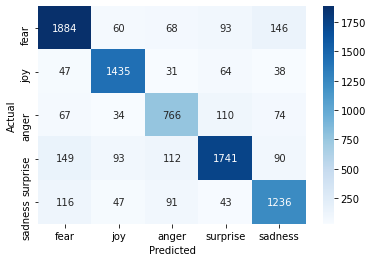

In [78]:
final_cm = copy.copy(confusion_matrices[0])
for cm in confusion_matrices[1:]:
    final_cm += cm
    
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'], 
            yticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
%%capture
with open('dumped_files/metrics_mlp_fixed.pickle', 'wb') as f:
    pkl.dump(metrics_mlp, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('dumped_files/cm_mlp_fixed.pickle', 'wb') as f:
    pkl.dump(confusion_matrices, f, protocol=pkl.HIGHEST_PROTOCOL)
    
for index, model in enumerate(trained_models):
    model.save('dumped_files/mlp_fixed_'+str(index))

## Random Forest based on Tfidf vectorizer

### Fixed model CV

In [24]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

confusion_matrices = []
metrics_rf = {'accuracy': [], 'f1_score_weighted': [], 'f1_score_micro': [], 'f1_score_macro': []}
emotion2number = {'fear': 0, 'joy': 1, 'anger': 2, 'surprise': 3, 'sadness': 4}
trained_models = []

for index, (train_index, test_index) in enumerate(skf.split(data['content'], data['sentiment'])):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    vectorizer = TfidfVectorizer()
    features_train = vectorizer.fit_transform(train['content'])
    features_test = vectorizer.transform(test['content'])
    dump(vectorizer, 'dumped_files/vectorizer_rf_fixed_'+str(index)+'.joblib')
    clf = RandomForestClassifier()
    
    clf.fit(features_train, train['sentiment'])
    trained_models.append(clf)
    
    predicted_categories = clf.predict(features_test)
    predicted_categories = [emotion2number[x] for x in predicted_categories]
    true_categories = [x[1]['sentiment'] for x in test.iterrows()]
    true_categories = [emotion2number[x] for x in true_categories]
    
    cm = confusion_matrix(true_categories, predicted_categories)
    confusion_matrices.append(cm)
    metrics_rf['accuracy'].append(accuracy_score(true_categories, predicted_categories))
    metrics_rf['f1_score_macro'].append(f1_score(true_categories, predicted_categories, average='macro'))
    metrics_rf['f1_score_micro'].append(f1_score(true_categories, predicted_categories, average='micro'))
    metrics_rf['f1_score_weighted'].append(f1_score(true_categories, predicted_categories, average='weighted'))

In [25]:
classification_report(metrics_rf)

accuracy mean 0.7999991953135059
accuracy std 0.008290851973257027
f1_score_weighted mean 0.8008868061564834
f1_score_weighted std 0.007857967035265423
f1_score_micro mean 0.7999991953135059
f1_score_micro std 0.008290851973257074
f1_score_macro mean 0.7986388052238124
f1_score_macro std 0.005931530122215835


Text(33.0, 0.5, 'Actual')

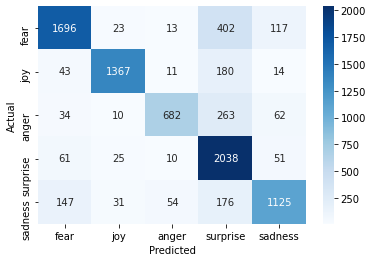

In [86]:
final_cm = copy.copy(confusion_matrices[0])
for cm in confusion_matrices[1:]:
    final_cm += cm
    
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'], 
            yticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [27]:
%%capture
with open('dumped_files/metrics_rf_fixed.pickle', 'wb') as f:
    pkl.dump(metrics_rf, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('dumped_files/cm_rf_fixed.pickle', 'wb') as f:
    pkl.dump(confusion_matrices, f, protocol=pkl.HIGHEST_PROTOCOL)
for index, model in enumerate(trained_models):
    dump(model, './dumped_files/rf_fixed_'+str(index)+'.joblib') 

### Tuning hyper-parameters

In [7]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

confusion_matrices = []
metrics_rf_tuning = {'accuracy': [], 'f1_score_weighted': [], 'f1_score_micro': [], 'f1_score_macro': []}
emotion2number = {'fear': 0, 'joy': 1, 'anger': 2, 'surprise': 3, 'sadness': 4}
trained_models = []

for index, (train_index, test_index) in enumerate(skf.split(data['content'], data['sentiment'])):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    vectorizer = TfidfVectorizer()
    features_train = vectorizer.fit_transform(train['content'])
    features_test = vectorizer.transform(test['content'])
    
    dump(vectorizer, 'dumped_files/vectorizer_rf_tuning_'+str(index)+'.joblib')
    #Preparing the validation split (20% of training set)
    ones = [-1]* int(len(train)*0.8)
    zeros = [0]* (len(train) - len(ones))
    test_fold = zeros + ones
    ps = PredefinedSplit(test_fold)
    
    rf = RandomForestClassifier()
    param_grid = {
                'n_estimators': range(100,200,10),
                'min_samples_split': [2,4,6],
                'min_samples_leaf': [1,2],
                'max_features': ['auto','sqrt','log2']
    }
    
    clf = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter=20, cv=ps) 
    search = clf.fit(features_train, train['sentiment'])
    best = search.best_estimator_
    trained_models.append(best)
    
    predicted_categories = best.predict(features_test)
    predicted_categories = [emotion2number[x] for x in predicted_categories]
    true_categories = [x[1]['sentiment'] for x in test.iterrows()]
    true_categories = [emotion2number[x] for x in true_categories]
    
    cm = confusion_matrix(true_categories, predicted_categories)
    confusion_matrices.append(cm)
    metrics_rf_tuning['accuracy'].append(accuracy_score(true_categories, predicted_categories))
    metrics_rf_tuning['f1_score_macro'].append(f1_score(true_categories, predicted_categories, average='macro'))
    metrics_rf_tuning['f1_score_micro'].append(f1_score(true_categories, predicted_categories, average='micro'))
    metrics_rf_tuning['f1_score_weighted'].append(f1_score(true_categories, predicted_categories, average='weighted'))

In [8]:
classification_report(metrics_rf_tuning)

accuracy mean 0.8274481245440111
accuracy std 0.010419486241387789
f1_score_weighted mean 0.8270097877624305
f1_score_weighted std 0.010366320038054216
f1_score_micro mean 0.8274481245440111
f1_score_micro std 0.010419486241387787
f1_score_macro mean 0.8224814770575561
f1_score_macro std 0.010389355392984342


Text(33.0, 0.5, 'Actual')

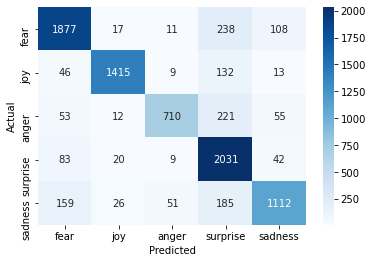

In [84]:
final_cm = copy.copy(confusion_matrices[0])
for cm in confusion_matrices[1:]:
    final_cm += cm
    
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'], 
            yticklabels=['fear', 'joy', 'anger', 'surprise', 'sadness'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [10]:
%%capture
with open('dumped_files/metrics_rf_tuning.pickle', 'wb') as f:
    pkl.dump(metrics_rf_tuning, f, protocol=pkl.HIGHEST_PROTOCOL)
with open('dumped_files/cm_rf_tuning.pickle', 'wb') as f:
    pkl.dump(confusion_matrices, f, protocol=pkl.HIGHEST_PROTOCOL)
for index, model in enumerate(trained_models):
    dump(model, './dumped_files/rf_tuning_'+str(index)+'.joblib') 

# Titanic Case Study

In [623]:
rnn = tf.keras.models.load_model('dumped_files/rnn_tuning_4')
mlp = tf.keras.models.load_model('dumped_files/mlp_fixed_9')
rf = load('dumped_files/rf_tuning_0.joblib')
vectorizer = load('dumped_files/vectorizer_rf_tuning_0.joblib')

In [624]:
with open('movie_dialog_corpus/movie_conversations.txt',"r") as f:
    conversations = f.readlines()

conversations = pd.DataFrame([x.split('+++$+++') for x in conversations])
conversations.columns = ['character_1', 'character_2', 'movie_id', 'sequence']
conversations['movie_id'] = conversations['movie_id'].str.replace(' ', '')
conversations['character_2'] = conversations['character_2'].str.replace(' ', '')
conversations['character_1'] = conversations['character_1'].str.replace(' ', '')

jack_rose_conversations_raw = conversations[(conversations['movie_id']=='m574') 
                                  & (conversations['character_2']=='u8462') 
                                  & (conversations['character_1']=='u8455')]['sequence']

In [625]:
jack_rose_conversations = list(filter(lambda x: 'L' in x, jack_rose_conversations_raw.iloc[0].split("'")))
for l in jack_rose_conversations_raw[1:]:
    jack_rose_conversations += list(filter(lambda x: 'L' in x, l.split("'")))

In [626]:
with open('movie_dialog_corpus/movie_lines.txt',"r") as f:
    lines = f.readlines()

lines = pd.DataFrame([x.split('+++$+++') for x in lines])
lines.columns=['line_id', 'character', 'movie_id', 'character_name', 'text']
lines['line_id'] = lines['line_id'].str.replace(' ', '')
lines['character'] = lines['character'].str.replace(' ', '')

jack_rose_utterances = lines[ lines.line_id.isin(jack_rose_conversations)]

In [627]:
rose_utterances_raw = jack_rose_utterances[jack_rose_utterances['character']=='u8462']
rose_utterances_raw = list(rose_utterances_raw.sort_values('line_id')['text'])
jack_utterances_raw = jack_rose_utterances[jack_rose_utterances['character']=='u8455']
jack_utterances_raw = list(jack_utterances_raw.sort_values('line_id')['text'])

In [628]:
jack_utterances_raw = pd.DataFrame(jack_utterances_raw, columns=['content'])
jack_utterances_raw = jack_utterances_raw.assign(sentiment = ['anger' for x in range(87)])
jack_utterances = jack_utterances_raw.applymap(func=normalize_text)
jack_utterances_dataset = create_tf_dataset(jack_utterances, 64)

rose_utterances_raw = pd.DataFrame(rose_utterances_raw, columns=['content'])
rose_utterances_raw = rose_utterances_raw.assign(sentiment = ['anger' for x in range(81)])
rose_utterances = rose_utterances_raw.applymap(func=normalize_text)
rose_utterances_dataset = create_tf_dataset(rose_utterances, 64)

In [609]:
jack_emotions_rnn = rnn.predict(jack_utterances_dataset)
jack_emotions_rnn = pd.DataFrame(jack_emotions_rnn, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])
jack_emotions_mlp = mlp.predict(jack_utterances_dataset)
jack_emotions_mlp = pd.DataFrame(jack_emotions_mlp, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])
jack_tfidf_features = vectorizer.transform(jack_utterances['content'])
jack_emotions_rf = rf.predict_proba(jack_tfidf_features)
jack_emotions_rf = pd.DataFrame(jack_emotions_rf, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])

2/2 [==============================] - 1s 320ms/step


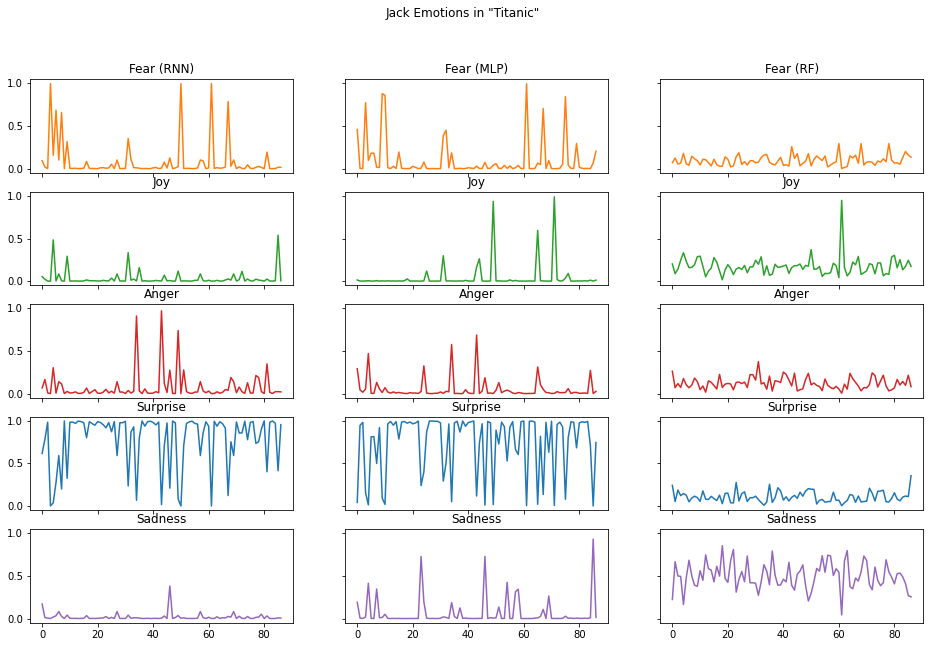

In [615]:
fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(16,10))
fig.suptitle('Jack Emotions in "Titanic"')
axs[0][0].set_title('Fear (RNN)')
axs[0][1].set_title('Fear (MLP)')
axs[0][2].set_title('Fear (RF)')
axs[0][0].plot(np.array(jack_emotions_rnn['fear']), 'tab:orange')
axs[0][1].plot(np.array(jack_emotions_mlp['fear']), 'tab:orange')
axs[0][2].plot(np.array(jack_emotions_rf['fear']), 'tab:orange')

axs[1][0].set_title('Joy')
axs[1][1].set_title('Joy')
axs[1][2].set_title('Joy')
axs[1][0].plot(np.array(jack_emotions_rnn['joy']), 'tab:green')
axs[1][1].plot(np.array(jack_emotions_mlp['joy']), 'tab:green')
axs[1][2].plot(np.array(jack_emotions_rf['joy']), 'tab:green')

axs[2][0].set_title('Anger')
axs[2][1].set_title('Anger')
axs[2][2].set_title('Anger')
axs[2][0].plot(np.array(jack_emotions_rnn['anger']), 'tab:red')
axs[2][1].plot(np.array(jack_emotions_mlp['anger']), 'tab:red')
axs[2][2].plot(np.array(jack_emotions_rf['anger']), 'tab:red')

axs[3][0].set_title('Surprise')
axs[3][1].set_title('Surprise')
axs[3][2].set_title('Surprise')
axs[3][0].plot(np.array(jack_emotions_rnn['surprise']))
axs[3][1].plot(np.array(jack_emotions_mlp['surprise']))
axs[3][2].plot(np.array(jack_emotions_rf['surprise']))

axs[4][0].set_title('Sadness')
axs[4][1].set_title('Sadness')
axs[4][2].set_title('Sadness')
axs[4][0].plot(np.array(jack_emotions_rnn['sadness']), 'tab:purple')
axs[4][1].plot(np.array(jack_emotions_mlp['sadness']), 'tab:purple')
axs[4][2].plot(np.array(jack_emotions_rf['sadness']), 'tab:purple')

plt.show()

In [629]:
rose_emotions_rnn = rnn.predict(rose_utterances_dataset)
rose_emotions_rnn = pd.DataFrame(rose_emotions_rnn, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])
rose_emotions_mlp = mlp.predict(rose_utterances_dataset)
rose_emotions_mlp = pd.DataFrame(rose_emotions_mlp, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])
rose_tfidf_features = vectorizer.transform(rose_utterances['content'])
rose_emotions_rf = rf.predict_proba(rose_tfidf_features)
rose_emotions_rf = pd.DataFrame(rose_emotions_rf, columns=  ['fear', 'joy', 'anger', 'surprise', 'sadness'])

2/2 [==============================] - 2s 488ms/step


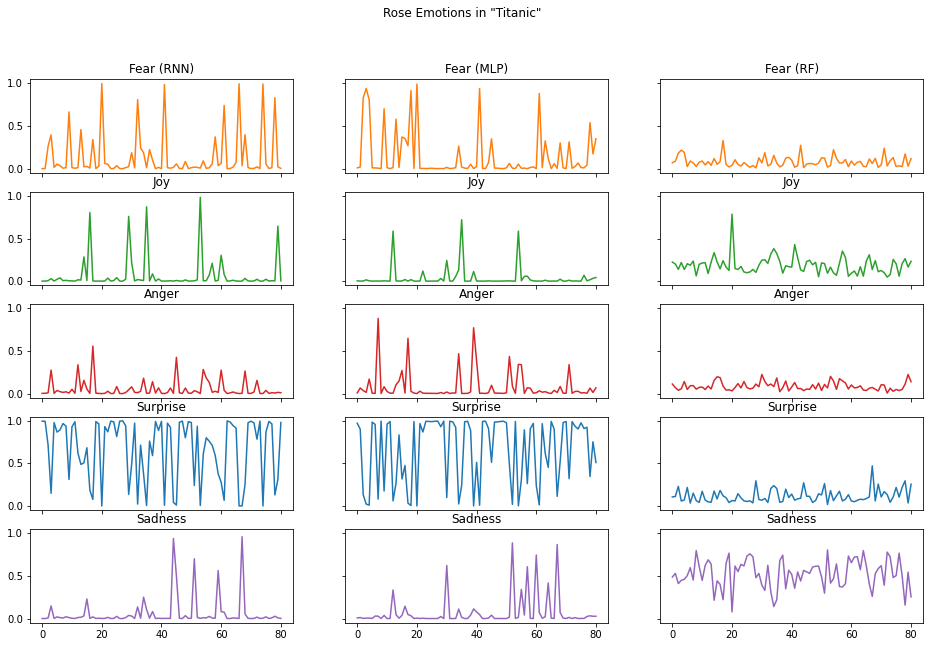

In [630]:
fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(16,10))
fig.suptitle('Rose Emotions in "Titanic"')
axs[0][0].set_title('Fear (RNN)')
axs[0][1].set_title('Fear (MLP)')
axs[0][2].set_title('Fear (RF)')
axs[0][0].plot(np.array(rose_emotions_rnn['fear']), 'tab:orange')
axs[0][1].plot(np.array(rose_emotions_mlp['fear']), 'tab:orange')
axs[0][2].plot(np.array(rose_emotions_rf['fear']), 'tab:orange')

axs[1][0].set_title('Joy')
axs[1][1].set_title('Joy')
axs[1][2].set_title('Joy')
axs[1][0].plot(np.array(rose_emotions_rnn['joy']), 'tab:green')
axs[1][1].plot(np.array(rose_emotions_mlp['joy']), 'tab:green')
axs[1][2].plot(np.array(rose_emotions_rf['joy']), 'tab:green')

axs[2][0].set_title('Anger')
axs[2][1].set_title('Anger')
axs[2][2].set_title('Anger')
axs[2][0].plot(np.array(rose_emotions_rnn['anger']), 'tab:red')
axs[2][1].plot(np.array(rose_emotions_mlp['anger']), 'tab:red')
axs[2][2].plot(np.array(rose_emotions_rf['anger']), 'tab:red')

axs[3][0].set_title('Surprise')
axs[3][1].set_title('Surprise')
axs[3][2].set_title('Surprise')
axs[3][0].plot(np.array(rose_emotions_rnn['surprise']))
axs[3][1].plot(np.array(rose_emotions_mlp['surprise']))
axs[3][2].plot(np.array(rose_emotions_rf['surprise']))

axs[4][0].set_title('Sadness')
axs[4][1].set_title('Sadness')
axs[4][2].set_title('Sadness')
axs[4][0].plot(np.array(rose_emotions_rnn['sadness']), 'tab:purple')
axs[4][1].plot(np.array(rose_emotions_mlp['sadness']), 'tab:purple')
axs[4][2].plot(np.array(rose_emotions_rf['sadness']), 'tab:purple')

plt.show()